In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

### Check if PyTorch recognizes GPU

In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Create function to extract frames from a video file

In [168]:
# https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html

def frame_extract(filepath, max_frames, frame_size):
    frames = []

    # begin reading from video
    capture = cv2.VideoCapture(filepath)
    if not capture.isOpened():
        print("Cannot open file")
        exit()
    while True:
        retval, image = capture.read()
        if not retval:
            break
        image = cv2.resize(image, frame_size)
        frames.append(image)

    # stop reading from video
    capture.release()

    # pad video by repeating animation until all samples are of equal length Holding -> 209
    # Pad video by repeating frames cyclically if it's shorter than max_frames
    while len(frames) < max_frames:
        num_padded = max_frames - len(frames)
        repeat_frames = frames[:num_padded]  # Repeat from the start
        frames.extend(repeat_frames)

    return np.array(frames)


#### Verify that the correct amount of frames are extracted

In [169]:
filename = 'Pointing_Day_Plain_front_30fps.mkv'
test_filepath = './dataset/Pointing/Day/Plain/' + filename
max_frames = 210 # longest animation is Holding_Something_In_Pain at 209 frames
frame_size = (208, 208)
test_frames = frame_extract(test_filepath, max_frames, frame_size)
print(test_frames.shape)# prints (num frames, height, width, channels)

(210, 208, 208, 3)


#### Display example frames from image sequence

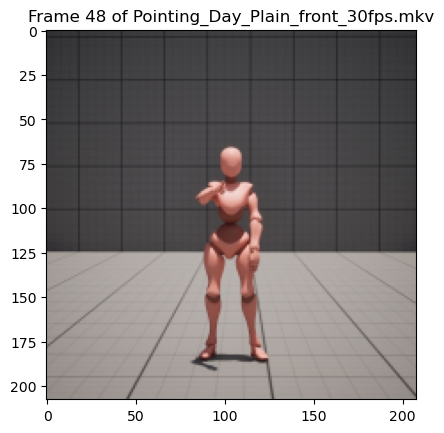

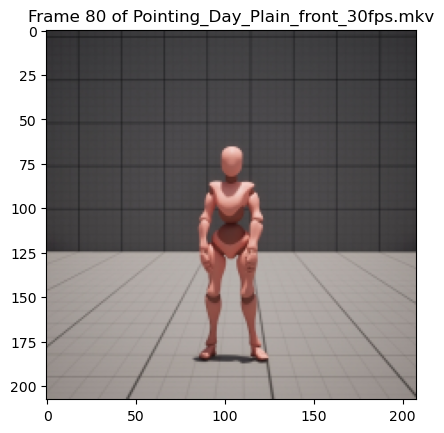

In [170]:
ex_frame1 = 48
example_frame = cv2.cvtColor(test_frames[ex_frame1], cv2.COLOR_BGR2RGB)

plt.imshow(example_frame)
plt.title(f'Frame {ex_frame1} of {filename}')
plt.show()

ex_frame2 = 80
example_frame2 = cv2.cvtColor(test_frames[ex_frame2], cv2.COLOR_BGR2RGB)
plt.imshow(example_frame2)
plt.title(f'Frame {ex_frame2} of {filename}')
plt.show()

### Define dataset with PyTorch

In [ ]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class DistressActionDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.labels = []
        self.data = []
        #self.transform = transform
        self.label_map = {
            "Holding_Something_In_Pain": 0,
            "Injured_Walk": 1,
            "Jumping": 2,
            "Pointing": 3,
            "Running": 4,
            "Waving": 5
        }

        # add all mp4's to 'videos', and appropriate label (as filepaths) to 'labels'
        # Labels: Holding_Something_In_Pain, Injured_Walk, Jumping, Pointing, Running, Waving
        for label_folder in os.listdir(root):
            label_filepath = os.path.join(root, label_folder)
            # Times: Day, Night
            for time_folder in os.listdir(label_filepath):
                time_filepath = os.path.join(label_filepath, time_folder)
                # Environments: Rural, Plain, Grassy
                for env_folder in os.listdir(time_filepath):
                    env_filepath = os.path.join(time_filepath, env_folder)
                    # Direction: Right, Left, Front, Back
                    for video in os.listdir(env_filepath):
                        if video.endswith(".mkv"):
                            video_file = os.path.join(env_filepath, video)
                            self.data.append(video_file)
                            self.labels.append(self.label_map[label_folder])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data[idx]
        label = self.labels[idx]

        frames = frame_extract(video_path, max_frames, frame_size)

        # put frames on tensor in (frames, channels, height, width) order
        # normalize pixel values
        frames = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
        # Apply transform to all frames in video
        # if self.transform:
        #     for i in range(len(frames)):
        #         frames[i] = self.transform(frames[i])
        
        # convert to tensor
        label = torch.tensor(label, dtype=torch.long)

        return frames, label

## Define Model using PyTorch

In [ ]:
# pretrained CNN models - https://pytorch.org/vision/0.9/models.html
from torchvision.models import resnet152

class DistressClassifier(nn.Module):
    def __init__(self, classes=6):
        super().__init__()
        self.resnet = resnet152(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 80))

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
            
        # TODO: can stack multiple LSTM cells with 'num_layers' arg
        self.lstm = nn.LSTM(input_size=80, hidden_size=64)
        self.fc1 = nn.Linear(64, 48)
        self.fc2 = nn.Linear(48, classes)
    
    def forward(self, x):
        hidden = None

        for t in range(x.size(1)):
            with torch.no_grad():
                resnet_x = self.resnet(x[:, t])  
            # pass latent representation of frame through lstm and update hidden state
            _, hidden = self.lstm(resnet_x.unsqueeze(0), hidden)         

        # get the last hidden state
        resnet_x = self.fc1(hidden[0][-1])
        resnet_x = F.relu(resnet_x)
        resnet_x = self.fc2(resnet_x)

        return resnet_x

#### Define Transforms

In [173]:
# from torchvision.transforms import v2

# augment = v2.Compose([
#     v2.RandomHorizontalFlip(),
#     v2.RandomVerticalFlip(),
#     v2.GaussianNoise()
# ])

### Segment Dataset into Training and Test portions.

In [ ]:
dataset_path = './dataset'
dataset = DistressActionDataset(dataset_path)
# 80% of dataset set aside for training, 20% for test
train_len = int(len(dataset)*0.8)      
train_set, test_set = random_split(dataset, [train_len, len(dataset)-train_len])

### Define DataLoader, Optimizer, Loss Function, and Model

In [ ]:
model = DistressClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

### Create Training Loop

In [176]:
# This training loop is modified from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_model(model, train_loader, optimizer, loss_fn, epoch_count):
    for epoch_index in range(epoch_count):
        print(f"Epoch {epoch_index + 1}/{epoch_count}")
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            # get sample, move to device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero gradients
            optimizer.zero_grad()

            # make predictions for batch
            outputs = model(inputs)

            # compute loss and gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # adjust learning weights
            optimizer.step()

            # gather training data and print periodically
            running_loss += loss.item()
        
            print(f"  Batch {i + 1} loss: {running_loss:.4f}")
            running_loss = 0.0

        print(f"Epoch {epoch_index + 1} complete. Last batch loss: {running_loss:.4f}")

### Train Model

In [177]:
epochs = 20
train_model(model, train_dataloader, optimizer, loss_fn, epochs)

Epoch 1/20
  Batch 1 loss: 1.7927
  Batch 2 loss: 1.8099
  Batch 3 loss: 1.8060
  Batch 4 loss: 1.7909
Epoch 1 complete. Last batch loss: 0.0000
Epoch 2/20
  Batch 1 loss: 1.7921
  Batch 2 loss: 1.7832
  Batch 3 loss: 1.7931
  Batch 4 loss: 1.7682
Epoch 2 complete. Last batch loss: 0.0000
Epoch 3/20
  Batch 1 loss: 1.7632
  Batch 2 loss: 1.7824
  Batch 3 loss: 1.7719
  Batch 4 loss: 1.7876
Epoch 3 complete. Last batch loss: 0.0000
Epoch 4/20
  Batch 1 loss: 1.7793
  Batch 2 loss: 1.7531
  Batch 3 loss: 1.7648
  Batch 4 loss: 1.7492
Epoch 4 complete. Last batch loss: 0.0000
Epoch 5/20
  Batch 1 loss: 1.7544
  Batch 2 loss: 1.7432
  Batch 3 loss: 1.7546
  Batch 4 loss: 1.7274
Epoch 5 complete. Last batch loss: 0.0000
Epoch 6/20
  Batch 1 loss: 1.7230
  Batch 2 loss: 1.7449
  Batch 3 loss: 1.7240
  Batch 4 loss: 1.7330
Epoch 6 complete. Last batch loss: 0.0000
Epoch 7/20
  Batch 1 loss: 1.7047
  Batch 2 loss: 1.7132
  Batch 3 loss: 1.7069
  Batch 4 loss: 1.6676
Epoch 7 complete. Last batc

### Create evaluation function

In [178]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network: {100 * correct / total} %')
    return accuracy


# Evaluate the model on the test set
accuracy = evaluate_model(model, test_dataloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Accuracy of the network: 37.93103448275862 %
Test Accuracy: 37.00%


### Save model weights

In [179]:
torch.save(model.state_dict(), f'./models/model_weights5-{accuracy:.1f}.pth')

#### Eval Function

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='macro') * 100
    recall = recall_score(all_labels, all_predictions, average='macro') * 100
    f1_score = ((2 * (precision * recall)) / (precision + recall)) / 100
    # Print
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'F1 Score: {f1_score:.2f}')

    return accuracy, precision, recall

# Evaluate the model
accuracy, precision, recall = evaluate_model(model, test_dataloader, device)